## Simulation on the Misaligned Setting

Denote the ground truth ranking of the algorithm and the human by $\pi_a^*$ and $\pi_h^*$.



In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
def benefit_of_human_simple(m, pi_h_star, phi_a, phi_h, verbose=False):
    Z_a = sum(np.exp(- phi_a * i) for i in range(0, m))
    Z_a_m_minus_1 = sum(np.exp(- phi_a * i) for i in range(0, m-1))
    Z_h = sum(np.exp(- phi_h * i) for i in range(0, m))

    assert(phi_a >= 0 and phi_h >= 0 and len(pi_h_star) == m)
    
    x1 = pi_h_star[0] # top item of human's ground truth ranking
    prob_joint_system_picking_x1 = 0
    for x_j in range(1, m+1):
        if x_j == x1:
            continue
        j = pi_h_star.index(x_j)
        k = j + 1 
        prob_of_presenting_x1_xj = (np.exp(-phi_a * (x1 + x_j - 2)) + np.exp(-phi_a * (x1 + x_j - 3))) / (Z_a * Z_a_m_minus_1)
        
        prob_rank_x1_before_xj = 1/2
        if phi_h > 0:
            prob_rank_x1_before_xj = k / (1 - np.exp(- phi_h * k)) - (k - 1) / (1 - np.exp(- phi_h * (k - 1)))
        
        prob_joint_system_picking_x1 += prob_of_presenting_x1_xj * prob_rank_x1_before_xj

    human_pick_best_prob = 1. / Z_h
    
    if verbose:
        print("Joint system picking x1: ", prob_joint_system_picking_x1)
        print("Human picks x1         : ", human_pick_best_prob)
        print("Joint - Human          : ", prob_joint_system_picking_x1 - human_pick_best_prob)
        print("\n")

    return prob_joint_system_picking_x1 - human_pick_best_prob

## Test cases
assert(benefit_of_human_simple(3, [1, 2, 3], 0, 0) == 0)
assert(benefit_of_human_simple(3, [1, 2, 3], 0.1, 0.1) > 0)
assert(benefit_of_human_simple(4, [1, 2, 3, 4], 0, 0) == 0)
assert(benefit_of_human_simple(4, [1, 2, 3, 4], 0.2, 0.2) > 0)

In [195]:
def sample_mallows(m, theta, pi_star=None):
    if pi_star is None:
        pi_star = list(range(1, m+1))
    
    permutation = [] 
    for i in range(1, m+1):
        possible_rs = np.arange(i)
        weights = np.array([1.0])
        for j in range(i-1):
            weights = np.insert(weights, 0, weights[0] * np.exp(-theta))
        weights /= np.sum(weights)
        
        r = np.random.choice(possible_rs, p=weights)
        permutation.insert(r, pi_star[i-1])
    return permutation

m = 10
theta = 1.0 

# no ground truth, [1,2,...,n] in default
sample_perm = sample_mallows(m, theta)
print("Sampled permutation:", sample_perm)

# with ground truth
pi_star = list(range(m, 0, -1))
sample_perm2 = sample_mallows(m, theta, pi_star)
print("Sampled permutation with pi_star =", pi_star,":", sample_perm2)


Sampled permutation: [2, 1, 3, 4, 7, 5, 10, 9, 6, 8]
Sampled permutation with pi_star = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1] : [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


## Experiment 1 (Complementarity under Misaligned and Equal-Acc Setting)

There exist cases where it is possible to achieve complementarity with **misaligned** and **equally accurate** algorithm (potential example?)

**Answer:** 
Yes, the following is an example, where 
* $\pi_a^* = [x_1, x_2, x_3, \ldots, x_{10}]$,
* $\pi_h^* = [x_2, x_1, x_{10}, \ldots, x_{3}]$
* $0 < \phi_a = \phi_h \le 0.3$


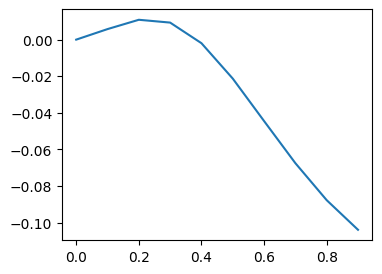

In [71]:
m = 10
slight_misaligned_pi_h_star = [2, 1] + [i for i in range(m, 2, -1)]

## Accuracy from 0 to 1
accs, benefits = [], []
for acc in np.arange(0, 1, 0.1):
    benefit = benefit_of_human_simple(m, slight_misaligned_pi_h_star, acc, acc)
    accs.append(acc)
    benefits.append(benefit)

plt.figure(figsize=(4, 3))
plt.plot(accs, benefits)
plt.show()

## Experiment 2: Aligned Human v.s. Misaligned Human

**Question:** Does there exist cases where misalignment may be helpful for accuracy. 
* e.g.: example where a misaligned human achieves complementarity, an aligned human doesn’t.

**Answer:** Yes, consider the following case, where
* The algorithm and the human have the same accuracy parameter $\phi$
* The misaligned human receives better benefit when $\phi$ is small

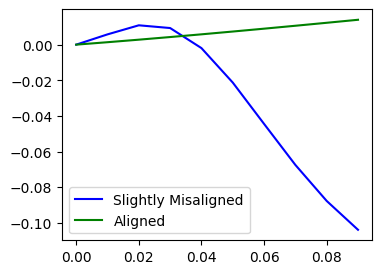

In [135]:
m = 10
aligned_pi_h_star = [i for i in range(1, m+1)]
slight_misaligned_pi_h_star = [2, 1] + [i for i in range(m, 2, -1)]

## Accuracy from 0 to 1
accs, aligned_benefits, misaligned_benefits = [], [], []
for acc in np.arange(0, 0.1, 0.01):
    aligned_benefit = benefit_of_human_simple(m, aligned_pi_h_star, acc, acc)
    misaligned_benefit = benefit_of_human_simple(m, slight_misaligned_pi_h_star, acc, acc)
    
    accs.append(acc)
    aligned_benefits.append(aligned_benefit)
    misaligned_benefits.append(aligned_benefit)

plt.figure(figsize=(4, 3))
plt.plot(accs, benefits, color='blue', label='Slightly Misaligned')
plt.plot(accs, aligned_benefits, color='green', label='Aligned')
plt.legend()
plt.show()

## Experiment 3: Misaligned Setting with Different Accuracy

In the above experiments, we focus on the case where the algorithm and the human have the same accurcy parameters. 

So what if they can be **differently accurate**? When does complementarity hold?

In the following experiment, we vary $\phi_a$ and $\phi_h$ to see the benefits of the human. In particular,

* We fix $\pi_a^* = [x_1, \ldots, x_m]$, and 
* consider the following three misaligned ground-truth:
    * $\pi_h^* = [x_2, x_1, x_3, \ldots, x_m]$;
    * $\pi_h^* = [x_2, x_1, x_m, \ldots, x_3]$;
    * $\pi_h^* = [x_m, x_{m-1},\ldots, x_1]$.



phi_h_star:  [2, 1, 3, 4, 5, 6, 7, 8, 9, 10]


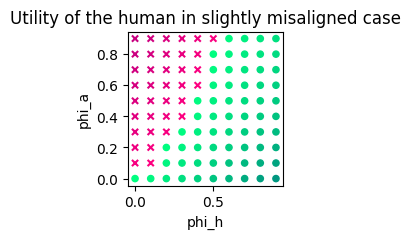

phi_h_star:  [2, 1, 10, 9, 8, 7, 6, 5, 4, 3]


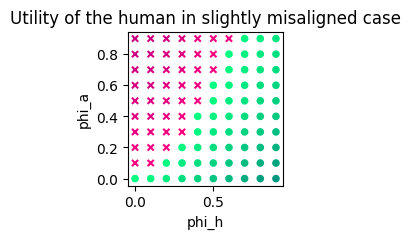

phi_h_star:  [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


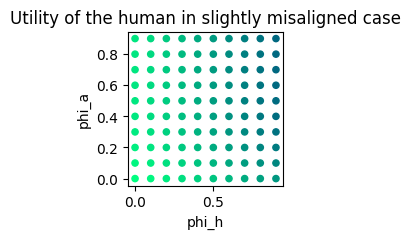

In [134]:
def diff_accurate_misaligned(phi_h_star):
    pos_phi_as, neg_phi_as = [], []
    pos_phi_hs, neg_phi_hs = [], []
    pos_colors, neg_colors = [], []

    print("phi_h_star: ", phi_h_star)
    for phi_a in np.arange(0, 1, 0.1):
        for phi_h in np.arange(0, 1, 0.1):
            utility = benefit_of_human_simple(m, phi_h_star, phi_a, phi_h)
            intensity = abs(utility) 
            color = (1 - intensity , 0, 0.5) if utility > 0 else (0, 1- intensity, 0.5)
            
            if utility > 0:
                pos_phi_as.append(phi_a)
                pos_phi_hs.append(phi_h)
                pos_colors.append(color)
            else:
                neg_phi_as.append(phi_a)
                neg_phi_hs.append(phi_h)
                neg_colors.append(color)
            
    fig = plt.figure(figsize=(2, 2))
    plt.scatter(pos_phi_hs, pos_phi_as, c=pos_colors, s=20, marker="x")
    plt.scatter(neg_phi_hs, neg_phi_as, c=neg_colors, s=20, marker="o")
    plt.xlabel("phi_h")
    plt.ylabel("phi_a")

    plt.title("Utility of the human in slightly misaligned case")
    plt.show()
    

misaligned_pi_h_star1 = [2, 1] + [i for i in range(3, m+1, 1)]
diff_accurate_misaligned(misaligned_pi_h_star1)

misaligned_pi_h_star2 = [2, 1] + [i for i in range(m, 2, -1)]
diff_accurate_misaligned(misaligned_pi_h_star2)

misaligned_pi_h_star3 = [i for i in range(m, 0, -1)]
diff_accurate_misaligned(misaligned_pi_h_star3)

## Experiment 4: A Possible Comparison with Other Pluralistic Framework 

> Most pluralistic alignment work is implicitly studying the case where human has perfect accuracy (e.g. I know my political opinions perfectly).  

This experiment aims to extend our setting to the scenario studied in other fluralistic framework. To be more specifc, we investigate the case where the human has **perfect accuracy**, but suffers from the scalability issue -- she can only perfectly identify the best item within a set of items with a **bounded size**. 

Consider the following scenario: 

* A professor is reviewing hundreds of PhD applications. Due to the heavy teaching and research workload, the professor has a probability of $p_i$ of missing an application $i$. The professor decides to meet with the students being considered.

* The professor has a keen eye for talent. After interviewing with the students, she is able to select the best applicant. However, among the emails she misses, some outstanding applicants may have been overlooked.
* Suppose there is an AI-tool that helps with reviewing the applicants. It can handle all the applicants in seconds. However, the tool is not very accurate. 
* So will it help the professor recruit the best PhD student by using AI to screen the resumes to get a shorter list and then reviews the students in the list?




In [199]:
m = 100  # Assume there are 100 students

## Expected index of the recruited student
def expect_index(m, p):
    expect_index = 0 
    for i in range(m):
        i_being_picked = 1
        for j in range(i):
            i_being_picked *= p[j]
        i_being_picked *= (1 - p[i])
        expect_index += i_being_picked * (i + 1)

    return expect_index

# Professor A: carefully review the resumes
# The probability of missing an applicant increases when the quality of student decreases
p_prof_A = [min(0.3 + 0.1*(i+1), 1) for i in range(m)]  

# Professor B: randomly review the resumes
# The probability of missing an applicant is the same
p_prof_B = [0.9 for _ in range(m)]

E_id_A = expect_index(m, p_prof_A)
E_id_B = expect_index(m, p_prof_B)
print("Expected index of the recruited student for Professor A: {}".format(E_id_A))
print("Expected index of the recruited student for Professor B: {}".format(E_id_B))

## Estimate the expected benefit with AI assitance
def expect_index_with_AI_assistance(k, phi_a, verbose=False):
    number_of_iter = 100
    expected_index_with_AI_assistance = 0
    for _ in range(number_of_iter):
        sampled_perm = sample_mallows(m, phi_a)
        short_list = sampled_perm[:k]
        if verbose:
            print("short list: ", short_list)
        expected_index_with_AI_assistance += min(short_list)
    expected_index_with_AI_assistance /= number_of_iter
    
    return expected_index_with_AI_assistance

## An highly accurate AI assistant
phi_a = 1
E_AI = expect_index_with_AI_assistance(10, phi_a)
print("Expected index with highly-accurate AI assistance: {}".format(E_AI))

## An mediumly accurate AI assistant
phi_a = 0.2
E_AI = expect_index_with_AI_assistance(10, phi_a)
print("Expected index with mediumly-accurate AI assistance: {}".format(E_AI))

## An zero accurate AI assistant
phi_a = 0
E_AI = expect_index_with_AI_assistance(10, phi_a)
print("Expected index with zero-accurate AI assistance: {}".format(E_AI))

Expected index of the recruited student for Professor A: 1.50832
Expected index of the recruited student for Professor B: 9.997078246122367
Expected index with highly-accurate AI assistance: 1.0
Expected index with mediumly-accurate AI assistance: 1.17
Expected index with zero-accurate AI assistance: 8.99
